# First Capstone: Analyzing Nice Ride data

[Nice Ride](https://www.niceridemn.com/) is Minneapolis' bike sharing program. A fleet of around 3,000 bikes are available seasonally, at stations located throughout the city. Users can become seasonal subscribers with 24/7 access, and both single-use and day pass options are available by paying via credit card at a Nice Ride station, or by using the Nice Ride mobile app.

[Nice Ride's data is publicly available](https://www.niceridemn.com/system-data), compiled monthly for the most recent biking season. Each "biking season" varies, but typically runs from April through November of a given year. (This is Minnesota, where winter riders are hardy, but few.)

Data for all previous seasons (2010 through the year before the current season's year) is compiled and made available per year.

__I chose the month of July, 2018 to analyze__--July is mid-season, so more trips will be available for analysis than would be available at either end of the season.

## What kind of data is available? 

The monthly data contains the following fields:
>* Trip Duration (seconds)
* Start Time and Date
* Stop Time and Date
* Start Station Name, ID (none if dockless ride)
* End Station Name, ID (none if dockless ride)
* Start and End Station Lat/Long (bike lat/long at start and end of rental if dockless ride)
* Bike ID
* User Type (Customer = Single ride or Day Pass; Subscriber = Annual or Monthly Member)
* Gender (Zero=unknown; 1=male; 2=female)
* Year of Birth<br><br>
>And rides have to last for at least 1 minute to be included in the Trip Data files.<br><br>
This data has been processed to remove trips that are taken by staff as they service and inspect the system, trips that are taken to/from any of our “test” stations at our warehouses and any trips lasting less than 60 seconds (potentially false starts or users trying to re-dock a bike to ensure it's secure).

## What kind of data _isn't_ available?

As I began thinking of questions to answer with this data, I realized it would have been nice to have additional information that is not a part of Nice Ride's public data sets.

* __Stations__: specifically, station capacity, and a continuous report of the number of bikes currently at a station.

* __Users__: we are only given customer "type" (subscriber vs. customer), gender, and year of birth in Nice Ride's public data. Their private data presumably has more customer-specific information, like a uniquely identifying customer number, that could be used to associate a customer to their trip history. We could have looked at the average number of trips each subscriber takes per week and their most frequently used stations, for instance.

* __Trips__: trip distance for the _bike_, not just the distance between the GPS coordinates of the start station and end station. It might have been interesting to calculate average miles per hour for different trips.

* __Weather__: Any outdoor activity is subject to the weather. This data could be sourced elsewhere, of course.

## Issues I found with Nice Ride's data

* The trip duration column had some extreme outliers--the maximum value was equivalent to 125 days. I chose to apply a maximum duration of 24 hours to this column, and I use those filtered records for the rest of the analysis. I will generate summary statistics before and after filtering, to show how those values are affected.
* There are a large number of records with a gender of 0/Unknown, and a birth year of 1969. I took these to be default values when the actual values are unknown.
    * I filter these records from the birth year graph.
    * Similarly, when looking at gender, I create two pie charts, including and excluding records where gender is Unknown, to give a better picture of the split between males and females.

## Package imports, reading data, functions

In [130]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import datetime
from IPython.display import display, Markdown, Latex
%matplotlib inline

### Input dataset

Here's where I define the name of the file we want to open, and open it.
 This notebook has been coded to handle Nice Ride's monthly data, which is available for every month of the most recent season.

My markdown sections are static, but you should be able to swap out the July 2018 data I analyzed with a file for one of the other months--summary statistics and graphs should update with values and labels specific to the data and the file containing it.

In [213]:
input_filename = '201807-niceride-tripdata.csv.zip'
df = pd.read_csv(input_filename)

# Let's also grab the month and year from the filename--we can use it in descriptions and titles.
# Nice Ride's filenames are consistent, so if we choose a different file to analyze later,
#  this date change will flow through the rest of this document.
yearmonth, junk = input_filename.split('-',1)
input_year = int(yearmonth[:4])

# Turn two-digit month into month name (07 --> "July")
input_month = int(yearmonth[4:])
input_month = datetime.date(input_year, input_month, 1).strftime('%B')

### Functions

In [214]:
def summary_duration_stats(series1,series2,desc1,desc2):
    series = {}
    series_stats = {}
    descriptions = {}
    series[1] = series1
    series[2] = series2
    descriptions[1] = desc1
    descriptions[2] = desc2

    for counter in (1, 2):
        series_stats[counter] = series[counter].describe()
        display(Markdown("\n### {}:".format(descriptions[counter].capitalize())))
        display(Markdown("* Total number of rides in {} {}: __{:.0f}__".\
                         format(input_month, input_year,series_stats[counter]['count'])))
        display(Markdown("* Shortest trip duration: __{} minutes__".\
                         format(series_stats[counter]['min'] / 60)))
        display(Markdown("* Longest trip duration: __{} minutes__".\
                         format(series_stats[counter]['max'] / 60)))
        display(Markdown("* Mean trip duration: __{:.4f} minutes__, with a standard deviation of __{:.4f} minutes__".\
                         format(series_stats[counter]['mean'] / 60, 
                                 series_stats[counter]['std'] / 60)))
        display(Markdown("* Median trip duration: __{:.4f} minutes__".\
                         format(series_stats[counter].median() / 60)))

# Calculate the difference between the mean and median of the two series
    mean_diff_sec = series_stats[1]['mean'] - series_stats[2]['mean']
    mean_diff_pct = series_stats[2]['mean'] / series_stats[1]['mean'] * 100

    median_diff_sec = series_stats[1].median() - series_stats[2].median()
    median_diff_pct = series_stats[2].median() / series_stats[1].median() * 100

    display(Markdown("\nThe difference in mean trip duration for {} and {} is __{:.4f} minutes__.".\
                     format(desc1,desc2,mean_diff_sec / 60)))
    display(Markdown("The mean trip duration of the {} is only __{:.2f}%__ of the {} mean.".\
                     format(desc2,mean_diff_pct,desc1)))
    display(Markdown("\nThe difference between median trip duration for {} and {} is __{:.4f} minutes__.".\
                     format(desc1,desc2,median_diff_sec / 60)))
    display(Markdown("The median trip duration of the {} is only __{:.2f}%__ of the {} median.".\
                     format(desc2,median_diff_pct,desc1)))

    diff_mean = series1.mean() - series2.mean()
    size = np.array([series1.count(),series2.count()])
    sd = np.array([series1.std(), series2.std()])
    diff_se = (sum(sd ** 2 / size)) ** 0.5

    t_and_p = ttest_ind(series2, series1, equal_var=False)
    display(Markdown("\n__T-value: {}__\n\n__P-value: {}__".\
                     format(t_and_p.statistic,
                            t_and_p.pvalue)
                    ))

In [215]:
def duration_boxplot(series):
    fig, ax_dur_box = plt.subplots(figsize=(24,6))

# Setting vert=False plots the data horizontally, which suits this data better.
    ax_dur_box = series.plot.box(vert=False)
    ax_dur_box.set_title('Durations of Nice Ride trips in {} {}, 24 hours or less'.\
                         format(input_month,input_year))

    ax_dur_box.set_xlabel('Duration in seconds')
    ax_dur_box.set_xticks(range(0,86400,3600))

    ax_dur_box.set_ylabel('Trips')
# Disable ticks for this graph--there's only one series of values anyway
    ax_dur_box.set_yticks([0])
    plt.show()

In [216]:
def subscriber_pie(series):
    fig, ax_c_vs_s = plt.subplots(figsize=(15,5))

    ax_c_vs_s.pie(series.value_counts(),
                  labels=['Customer','Subscriber'],
                  autopct='%1.1f%%',startangle=90)

    ax_c_vs_s.set_title('Nice Ride customers and subscribers in {} {}\n({} records)'\
                        .format(input_month,
                                input_year,
                                series.count())
                       )
    plt.show()

In [217]:
def stations_bar(series,barcolor,title, **kwargs):
# x_max is an optional value to define the max value for the x-axis
    x_max = kwargs.get('x_max', None)

# Set a range of colors to make these graphs look a little more interesting.
#    get_cmap will create a range of colors. We can then give this object
#    a value from the series and it will return a color--
#    light to dark colors representing low to high values.
    my_cmap = plt.get_cmap(barcolor,max(series))

    fig, ax_top_x = plt.subplots(figsize=(20,8))
    ax_top_x = series.plot.barh(color=my_cmap(series))

    ax_top_x.set_title(title)
    ax_top_x.set_xlabel('Number of trips')
    ax_top_x.set_ylabel('Station locations')

    if x_max is not None:
        plt.xlim(0,x_max)

# Add the actual counts to the end of each bar too.
    for i, value in enumerate(series):
        ax_top_x.text(value, i, " "+str(value),
                      color='black', va='center', fontweight='bold')
    plt.show()

In [218]:
def birth_year_histogram(series, **kwargs):
# title is an optional title for the graph--if not provided, a generic one is created.
    title = kwargs.get('title','Birth year of Nice Ride riders in {} {}, where known ({} records)'\
                       .format(input_month,
                               input_year,
                               series.count())
                      )
    fig2, ax_age = plt.subplots(figsize=(15,8))

# We can use the highest frequency in the data to place a text box on the graph
    textbox_y_pos = max(series.value_counts()[:1])

# Create enough bins for the histogram to cover the full range of values.
#    Add 1 to the latest year, so a bin for it is included.
    num_bins = np.arange(series.min(),
                         series.max() + 1)

# Create the histogram. N represents the histogram values;
#    bins defines the edges of each bin;
#    patches gives us a way to define the color of each bar of the histogram.
    N, bins, patches = ax_age.hist(series,num_bins)

# fracs is an array with a value between 0 and 1 for each bar of the histogram,
#    that is used to choose a color from the colormap
    fracs = N.astype(float) / N.max()
    norm = colors.Normalize(fracs.min(),fracs.max())

    for thisfrac, thispatch in zip(fracs,patches):
            color = plt.cm.plasma(norm(thisfrac))
            thispatch.set_facecolor(color)
    ax_age.set_xlabel('Birth Year')
    ax_age.set_ylabel('Count')
    ax_age.set_title(title)
# Add a text box with some summary statistics and trivia to the upper left.
    ax_age.text(series.min(),
                textbox_y_pos * .9,
                "The mean birth year is {:.0f}; the mode is {}.\nThe oldest Nice Ride rider in this data set was born in {}!"\
                .format(series.mean(),
                        series.mode()[0],
                        series.min()),
                fontsize=14,
                bbox={'facecolor':'blue', 'alpha':0.1, 'pad':10})
    plt.show()

In [219]:
def duration_histogram(dataframe, **kwargs):
    usertype = kwargs.get('usertype','All')
    barcolor = kwargs.get('barcolor','black')
    x_lim = kwargs.get('x_lim',None)
    y_lim = kwargs.get('y_lim',None)

    fig, ax_dur_hist = plt.subplots(figsize=(24,8))

# Plot a frequency of ride durations. 24 hours, 5-minute intervals = 288 bins
    ax_dur_hist = dataframe['tripduration'].apply(lambda x: x / 60).plot.hist(bins=288,
                                                                              alpha=.5,
                                                                              color=barcolor)
                                                    
    ax_dur_hist.set_title('Durations of {} Nice Ride trips in {} {}, 24 hours or less--showing rides under 200 minutes'.\
                          format(usertype.lower(),
                                 input_month,
                                 input_year))
    ax_dur_hist.set_xlabel('Minutes')
    ax_dur_hist.set_ylabel('Trip frequency')
    ax_dur_hist.set_xticks(range(0,1440,5))

# Trip stats text box:
    ax_dur_hist.text(.25, .55,
                     "{} trips ({} riders):\nMean: {:.2f} minutes;\nMedian: {:.2f} minutes"\
                     .format(usertype,
                             dataframe['tripduration'].count(),
                             dataframe['tripduration'].mean() / 60,
                             dataframe['tripduration'].median() / 60),
                     fontsize=14,
                     transform=ax_dur_hist.transAxes,
                     verticalalignment='top',
                     bbox={'facecolor':barcolor, 'alpha':0.1, 'pad':10})
    if x_lim:
        plt.xlim(0,x_lim)        
    if y_lim:
        plt.ylim(0,y_lim)

    plt.show()

# We can use the y-axis limits to scale other graphs, for better visual comparisons
    if usertype == 'All':
        return ax_dur_hist.get_ylim()

In [220]:
def gender_pies(series):
        
    fig, (ax_gender_all,ax_gender_filtered) = plt.subplots(1,2,figsize=(15,5))

    ax_gender_all.pie(series.value_counts(),
                      labels=['Unknown','Male','Female'],
                      autopct='%1.1f%%',startangle=90)

    ax_gender_all.set_title('Reported gender of Nice Ride riders in {} {}\n({} records)'\
                            .format(input_month,
                                    input_year,
                                    series.count())
                           )
    series_gender_filtered = series.loc[(series != 0)]
    ax_gender_filtered.pie(series_gender_filtered.value_counts(),
                           labels=['Male','Female'],
                           autopct='%1.1f%%',startangle=90)
    ax_gender_filtered.set_title('Reported gender of Nice Ride riders in {} {},\nexcluding riders where gender is unknown ({} records)'\
                                 .format(input_month,
                                         input_year,
                                         series_gender_filtered.count())
                                )
    plt.show()

In [221]:
def make_colorbar():
    # Make a figure and axes with dimensions as desired.
    fig = plt.figure(figsize=(8, 3))
    ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
    cmap = mpl.cm.RdYlGn
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    ticks=[0,.5,1],
                                    orientation='horizontal')
    cb1.ax.set_xticklabels(['Source','Neutral','Destination'])
    cb1.set_label('Station flow')

In [222]:
def station_map(df,**kwargs):
    lat = kwargs.get('lat','start station latitude')
    long = kwargs.get('long','start station longitude')
    station_id = kwargs.get('station_id','start station id')
    flow_extreme = kwargs.get('flow_extreme', False)
    flow_low = kwargs.get('flow_low',.25)
    flow_high = kwargs.get('flow_high',.75)

    extremes = 'extremes < {} and > {} '.format(flow_low,flow_high) if flow_extreme else ''

    title = kwargs.get('title','Map of Nice Ride stations, frequency and flow {}in {} {} '\
                       .format(extremes,
                               input_month,
                               input_year))

# Overall station frequency
    station_freq = df[station_id].value_counts()

    start_station_freq = df['start station id'].value_counts().sort_index()
    end_station_freq = df['end station id'].value_counts().sort_index()

# Concatenate/sort/dedup station ids to be sure we have all of them
    station_id_list = np.unique(np.concatenate((start_station_freq.index,
                                                end_station_freq.index),0))

# Construct a Series of station ids w/the difference of 
#    bikes arriving at/bikes leaving each station (I'm calling this difference "flow")
    station_freq_list = []
    for station in station_id_list:
        flow_diff = start_station_freq.get(station,0) - end_station_freq.get(station,0)
        station_freq_list.append(flow_diff)

    station_flow = pd.Series(station_freq_list, station_id_list)

# Normalize the flow values.
    station_flow = station_flow.map(lambda x:
                                    (x - station_flow.min()) /
                                    (station_flow.max() - station_flow.min())
                                   )

# Only plot the stations with extreme flow if flow_extreme = True.
    if flow_extreme == True:
# This dataframe will be easier to join to than the series
        df_station_flow = pd.DataFrame(zip(station_id_list,station_flow),
                                       columns=[station_id,'flow'])
        df_flow_extremes = pd.concat([df_station_flow.loc[df_station_flow['flow'] < flow_low],
                                      df_station_flow.loc[df_station_flow['flow'] > flow_high]])
        df_plot = pd.merge(df,df_flow_extremes,
                           on=station_id,
                           how='inner')
    else:
        df_plot = df

    my_cmap = plt.get_cmap('RdYlGn')

# Determine min/max latitude and longitude based on the data we have to plot.
#    Apparently lat/long coordinates need to be rounded to 3 decimal places
    pad = .01
    min_lat = round(df_plot[lat].min() - pad,3)
    max_lat = round(df_plot[lat].max() + pad,3)
    min_long = round(df_plot[long].min() - pad,3)
    max_long = round(df_plot[long].max() + pad,3)

    fig, ax = plt.subplots(figsize=(15,15))
    map = Basemap(projection='merc',
                  llcrnrlat=min_lat, llcrnrlon=min_long,
                  urcrnrlat=max_lat, urcrnrlon=max_long,
                  resolution=None, epsg=4269)
    map.arcgisimage(service='World_Topo_Map')
    map.scatter(df_plot[long], df_plot[lat], latlon=True,
                s=station_freq[df_plot[station_id]],
                c=my_cmap(station_flow[df_plot[station_id]]),
                alpha=.1)
    ax.legend(['Point size denotes overall frequency of use'],
              fontsize=14)
    ax.set_title(title + "({} records)".format(df_plot[station_id].count()))

    make_colorbar()
    plt.show()

## Applying filters to Nice Ride duration data

Nice Ride have already filtered rides with a duration of less than 60 seconds from their public data, but there are some extreme outliers at the other end of the range as well. The longest duration in the July 2018 data is 10858405 seconds, or over 125 days.

I chose to further filter the data set by only allowing values under 86,400 seconds (24 hours). I would wager that this is still far longer than anyone would keep a Nice Ride bike, but at a minimum it is more reasonable than 125 days.

This 24-hour max filter only removes 205 records from the data set, but that handful of records substantially affects the mean and median trip durations, shown below.

__Note that this filtered data set is used for the analysis in the remaining sections.__

In [223]:
df_one_day_duration = df.loc[df['tripduration'] <= 86400]

In [224]:
summary_duration_stats(df['tripduration'],
                       df_one_day_duration['tripduration'],
                       "all trips",
                       "trips taking less than 24 hours")


### All trips:

* Total number of rides in July 2018: __86008__

* Shortest trip duration: __1.0166666666666666 minutes__

* Longest trip duration: __180973.41666666666 minutes__

* Mean trip duration: __73.0779 minutes__, with a standard deviation of __1839.5418 minutes__

* Median trip duration: __50.6056 minutes__


### Trips taking less than 24 hours:

* Total number of rides in July 2018: __85803__

* Shortest trip duration: __1.0166666666666666 minutes__

* Longest trip duration: __1436.4 minutes__

* Mean trip duration: __27.9609 minutes__, with a standard deviation of __71.1679 minutes__

* Median trip duration: __27.9888 minutes__


The difference in mean trip duration for all trips and trips taking less than 24 hours is __45.1170 minutes__.

The mean trip duration of the trips taking less than 24 hours is only __38.26%__ of the all trips mean.


The difference between median trip duration for all trips and trips taking less than 24 hours is __22.6168 minutes__.

The median trip duration of the trips taking less than 24 hours is only __55.31%__ of the all trips median.


__T-value: -7.1874467108973406__

__P-value: 6.654623018988109e-13__

The T-value and P-value for the entire set of data vs. the data with a maximum trip duration of 24 hours applied suggests it is highly unlikely that the two samples are the same.

The box plot below shows us that even the filtered trip duration has a lot of large outliers, but that the duration of most trips are still tightly grouped around the mean.

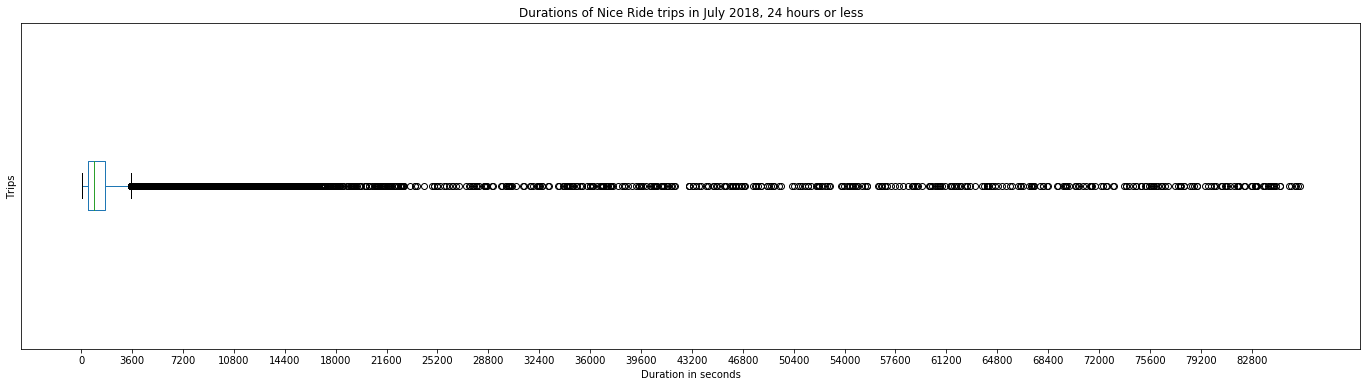

In [225]:
duration_boxplot(df_one_day_duration['tripduration'])

## Customer vs. Subscriber

Over 70% of Nice Ride trips in July 2018 were taken by riders who purchased single-ride or single-day rentals--in the data, these rides have a user type of "Customer". Trips taken by Nice Ride subscribers make up the remainder.

This data isn't super interesting in itself, but the distinction between customers and subscribers becomes more important when looking at other rider-related fields, like gender and age--subscribers' ages and genders are consistently populated, while customers' information is not.

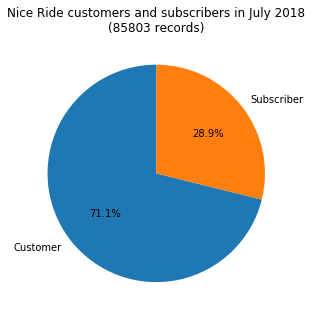

In [226]:
subscriber_pie(df_one_day_duration['usertype'])

## Comparing customer trip durations to subscriber trip durations

It also makes sense to divide Nice Ride's data into customers vs. subscribers when comparing trip durations, because different rules apply to each group.

Single Nice Ride rentals are a flat fee for the first half hour, with additional charges accruing for every additional 30 minutes.

Day pass purchasers can take unlimited 30-minute rides within 24 hours.

Subscribers to Nice Ride can take unlimited trip of up to 60 minutes for no additional charge.

Given that information, I'm curious whether subscribers are taking advantage of their ability to take longer rides. My expectation is that they are.

In [227]:
df_customers = df_one_day_duration.loc[df_one_day_duration['usertype'] == 'Customer']
df_subscribers = df_one_day_duration.loc[df_one_day_duration['usertype'] == 'Subscriber']

### Summary statistics

In [228]:
summary_duration_stats(df_customers['tripduration'],
                       df_subscribers['tripduration'],
                       "customer trips",
                       "subscriber trips")


### Customer trips:

* Total number of rides in July 2018: __61029__

* Shortest trip duration: __1.0166666666666666 minutes__

* Longest trip duration: __1436.4 minutes__

* Mean trip duration: __33.1453 minutes__, with a standard deviation of __80.9638 minutes__

* Median trip duration: __32.3976 minutes__


### Subscriber trips:

* Total number of rides in July 2018: __24774__

* Shortest trip duration: __1.0166666666666666 minutes__

* Longest trip duration: __1432.4166666666667 minutes__

* Mean trip duration: __15.1895 minutes__, with a standard deviation of __34.1246 minutes__

* Median trip duration: __16.1864 minutes__


The difference in mean trip duration for customer trips and subscriber trips is __17.9557 minutes__.

The mean trip duration of the subscriber trips is only __45.83%__ of the customer trips mean.


The difference between median trip duration for customer trips and subscriber trips is __16.2112 minutes__.

The median trip duration of the subscriber trips is only __49.96%__ of the customer trips median.


__T-value: -45.6939894700555__

__P-value: 0.0__

Comparing the summary statistics for these two categories of trips is eye-opening. Subscribers are, on average, taking much _shorter_ trips than single-ride or day pass customers. The mean for customers is actually slightly over the 30-minute limit too, which is also unexpected.

I compute the T-value and P-value for these two categories of rides, but all they seem to indicate is that the range of trip durations is so broad for both customers and subscribers that there's no chance the two distributions are the same.


### Plotting trip durations for Nice Ride customers and subscribers

The distribution of the frequency of trip durations looks like a Pareto curve. In the following plots, just the first 200 minutes' worth of data points are shown, to make the shape of the distribution curves more apparent.

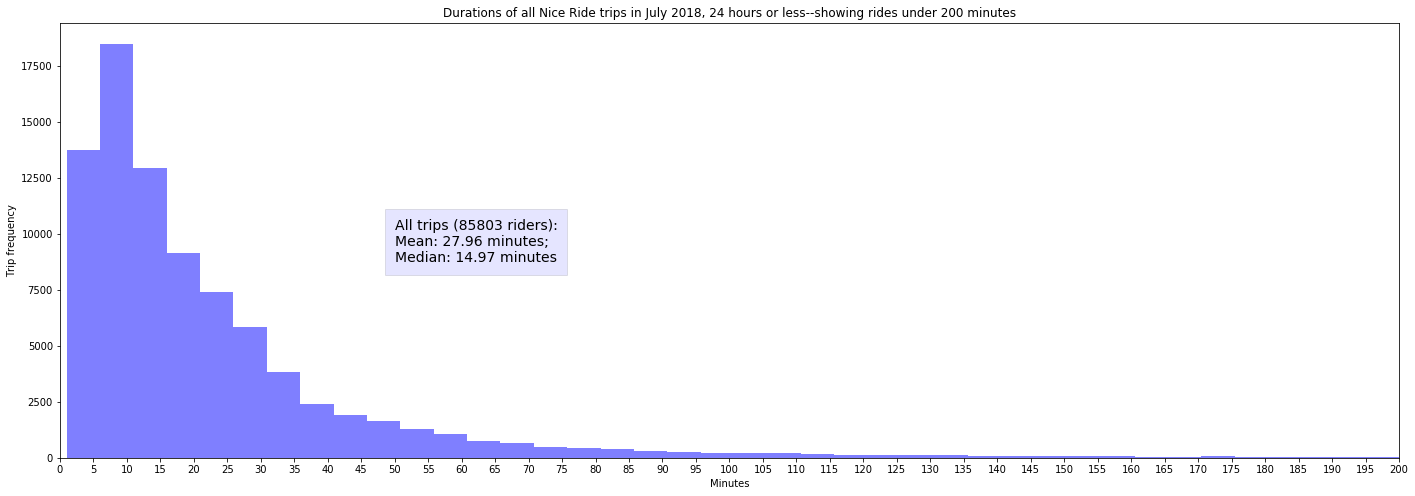

In [229]:
# (Also capture the limits of the y-axis so we can use them in subsequent trip duration plots)
duration_all_ylim_min, duration_all_ylim_max = duration_histogram(df_one_day_duration,
                                                                  barcolor='blue',
                                                                  x_lim=200)

It is not surprising that the overwhelming majority of rides are under 60 minutes, with the overall mean just under 28 minutes.

We can also look at just the customers' trip durations:

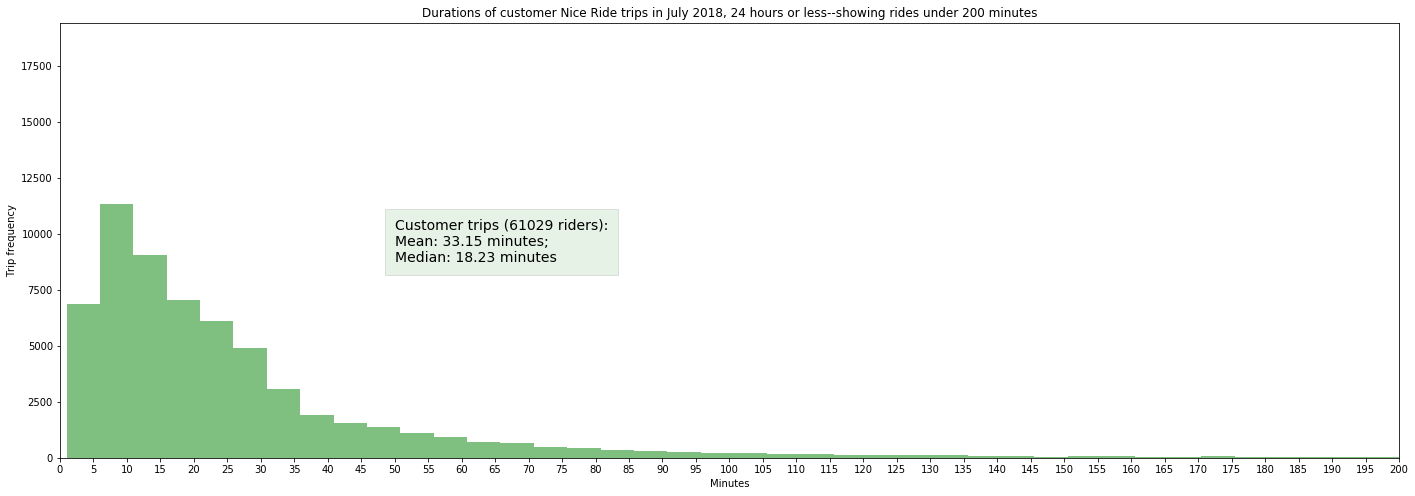

In [230]:
duration_histogram(df_customers,
                   barcolor='green',
                   usertype='Customer',
                   x_lim=200,
                   y_lim=duration_all_ylim_max)

...And subscribers' trip durations:

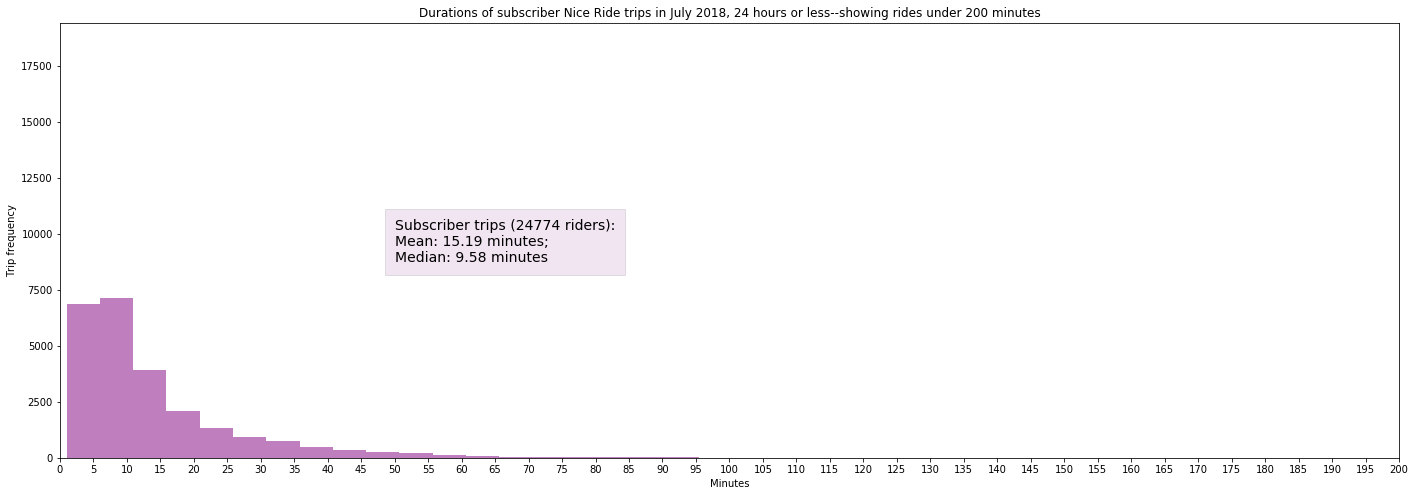

In [231]:
duration_histogram(df_subscribers,
                   barcolor='purple',
                   usertype='Subscriber',
                   x_lim=200,
                   y_lim=duration_all_ylim_max)

Again, it is surprising to me that subscriber trips are, on average, shorter than single-ride or day pass customer trips. I would have guessed subscribers would take advantage of their ability to ride longer.

It's not possible to uniquely identify riders in Nice Ride's public data, so I don't know how many subscribers this data represents. Maybe a subset of subscribers are taking lots of short trips each day, pulling down the average trip duration for the entire group?

## Who is the typical Nice Ride rider? Which demographics might Nice Ride want to target to increase ridership, or subscribership?

If Nice Ride is interested in increasing ridership or subscribership, in addition to having bikes available at stations at popular locations, they need to determine who is actually riding their bikes.

We don't have a lot of customer-specific information in Nice Ride's public data, but we do have gender and birth year, so let's look at those.

__No uniquely identifying rider data is included in this set, so the statistics in this section are all based on reported values from each trip taken in July 2018.__

### Rider gender

Nice Ride has gender and age information about their subscribers, and riders who use the Nice Ride app.

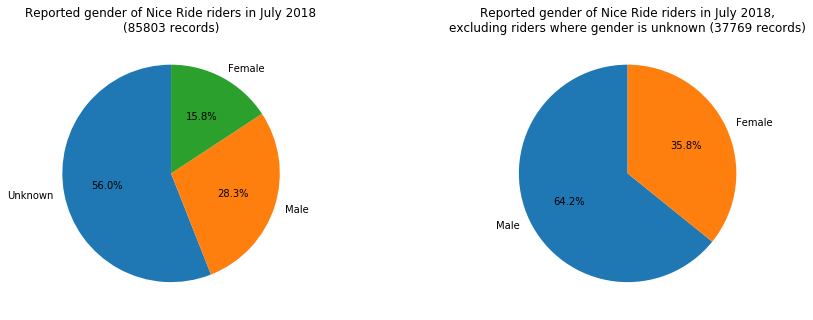

In [232]:
gender_pies(df_one_day_duration['gender'])

Without more complete data regarding gender, making confident decisions is tougher--but if the gender data Nice Ride collected is representative of Nice Ride users in general, and Nice Ride is interested in increasing ridership, they may want to tailor some marketing campaigns to appeal to women specifically. 

I looked at data for a few other months from 2018, and the percentages for gender remained the same from month to month. It's likely that this split is representative of Nice Ride users.

### Analyzing rider birth year

Birth year is consistently populated, even for trips where gender, another rider-related field, is unknown.

As with gender above, there is no way to uniquely identify a Nice Ride rider with the given data. These values represent the reported birth year of a rider for each trip in July 2018.

I noticed that around 40,000 records where gender is unknown have a birth year of 1969--it seems that combination of values represents a rider for whom both gender and birth year are not known. 

__To make more sense of the birth year data, I dropped records with a birth year of 1969 and a gender of Unknown for the analysis in this section__. 

I checked the frequencies of the User Type field before and after applying this filter to confirm that customer records were filtered more often than subscriber records, and found this to be overwhelmingly true. For the July 2018 data, the filter only removes 49 Subscriber records, and over 40,000 Customer records:

In [233]:
# The breakdown of customer vs. subscriber in the 24-hour filtered data
df_one_day_duration['usertype'].value_counts()

Customer      61029
Subscriber    24774
Name: usertype, dtype: int64

In [234]:
# There are around 40,000+ entries with birth year==1969.
# This seems to be a default value because it appears most frequently when gender==0.
# Let's filter out these rows.
df_filtered_age = df_one_day_duration.loc[~((df_one_day_duration['birth year'] == 1969) & \
                                            (df_one_day_duration['gender'] == 0))]
df_filtered_age['usertype'].value_counts()

Subscriber    24725
Customer      19762
Name: usertype, dtype: int64

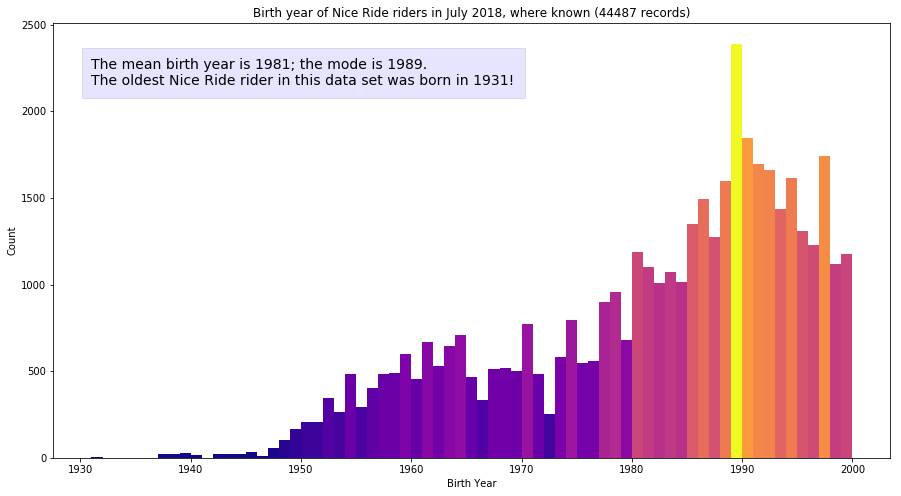

In [235]:
birth_year_histogram(df_filtered_age['birth year'])

Out of sheer curiosity, I looked at the records in the July 2018 data set where the birth year is 1931. There are four short customer trips around the downtown area, all under a half hour, in the middle of the day. (I hope I'm still riding a bike when I'm in my late 80s!)

Birth year is consistently populated for most subscribers, so we can take a look at how those numbers look as well:

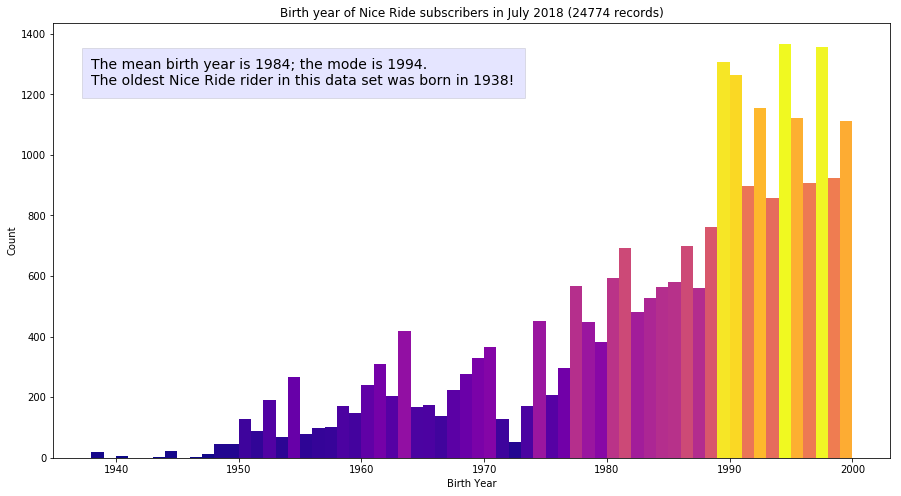

In [236]:
birth_year_histogram(df_subscribers['birth year'],
                     title="Birth year of Nice Ride subscribers in {} {} ({} records)"\
                     .format(input_month,
                             input_year,
                             df_subscribers['birth year'].count())
                    )

Some really quick numbers to further explain the distribution:

In [237]:
df_subscribers['birth year'].describe()

count    24774.000000
mean      1984.084807
std         12.708524
min       1938.000000
25%       1977.000000
50%       1988.000000
75%       1994.000000
max       2000.000000
Name: birth year, dtype: float64

This distribution of subscribers' birth year skews young--a mean of 34 years old, $\pm$12.7 years. The 18-35 age group represents over half of subscribers, with the other half spread across almost 50 years--the max age in July 2018 is 80 years old. 

The average age of overall riders in July 2018 is a few years older than the average for subscribers:

In [238]:
df_filtered_age['birth year'].describe()

count    44487.000000
mean      1981.154809
std         13.449861
min       1931.000000
25%       1972.000000
50%       1985.000000
75%       1992.000000
max       2000.000000
Name: birth year, dtype: float64

So (slightly) older people are riding Nice Ride bikes in respectable numbers, but they are not as enthusiastic about taking advantage of a subscription.

Nice Ride offers student discounts, which may account for why the subscriber age is younger.

I know some employers offer incentives to employees to engage in more active and healthy lifestyles--maybe Nice Ride could partner with a company like Optum, so that people who have a Nice Ride subscription can track their trips, and get health and wellness dollars for their HSA in return.

## Where are the most popular and least popular Nice Ride stations?

Nice Ride employees work throughout the day, performing a task known as balancing. Balancers take bikes from stations where future demand is anticipated to be lower, and deliver those bikes to stations where demand is expected to be higher. They also remove bikes from popular stations, to leave room for people to park additional bikes.

Nice Ride looks for patterns in trip data to identify stations with high anticipated demand that are already at or near capacity, and stations that will need to have bikes delivered to them, before anticipated spikes in demand. A team of "balancers" redistributes bikes among stations based on this data, to either make room for additional bikes at a station, or to make more bikes available.

I decided to take a look at trip information to identify the most and least in-demand stations, and the stations where there is not a balance of bikes leaving/bikes arriving. These are the stations with which Nice Ride balancers should become very familiar in coming seasons.

### Popular starting stations

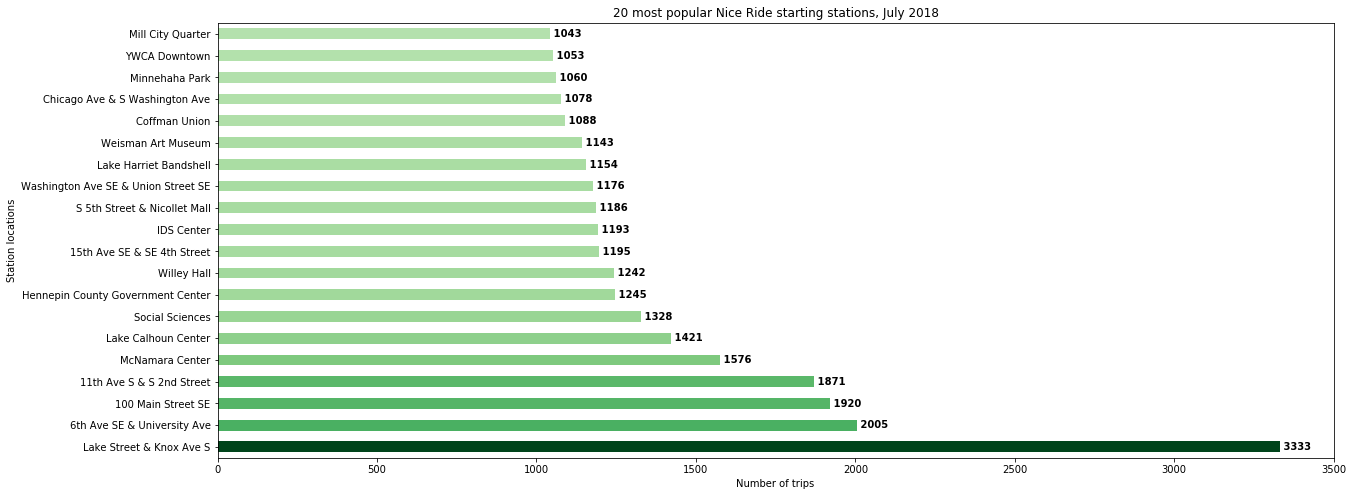

In [239]:
top_20_start_stations = df_one_day_duration['start station name'].value_counts()[:20]

stations_bar(top_20_start_stations,
             'Greens',
             '20 most popular Nice Ride starting stations, {} {}'\
             .format(input_month,input_year)
            )

### Popular end stations

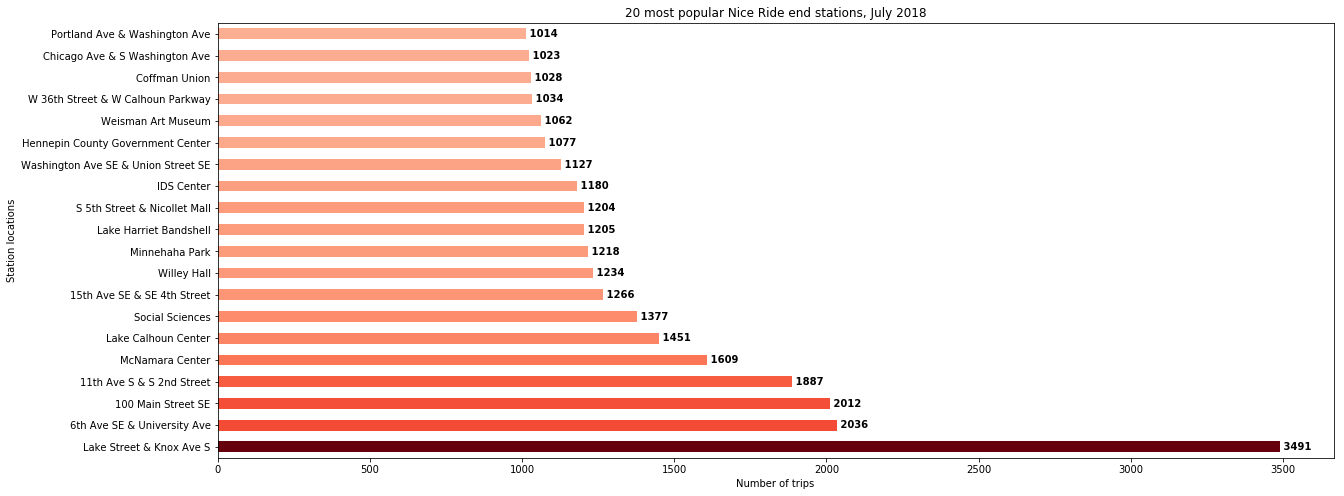

In [240]:
top_20_end_stations = df_one_day_duration['end station name'].value_counts()[:20]

stations_bar(top_20_end_stations,
             'Reds',
             '20 most popular Nice Ride end stations, {} {}'\
             .format(input_month,input_year)
            )

### Where start and end stations for a trip are the same

The nearly identical locations on the start and end station lists made me curious about the most popular stations where the start and end of a trip are the same. 

Stations on this list may of particular interest to balancers, since bikes that are taken from these stations often return to them. 

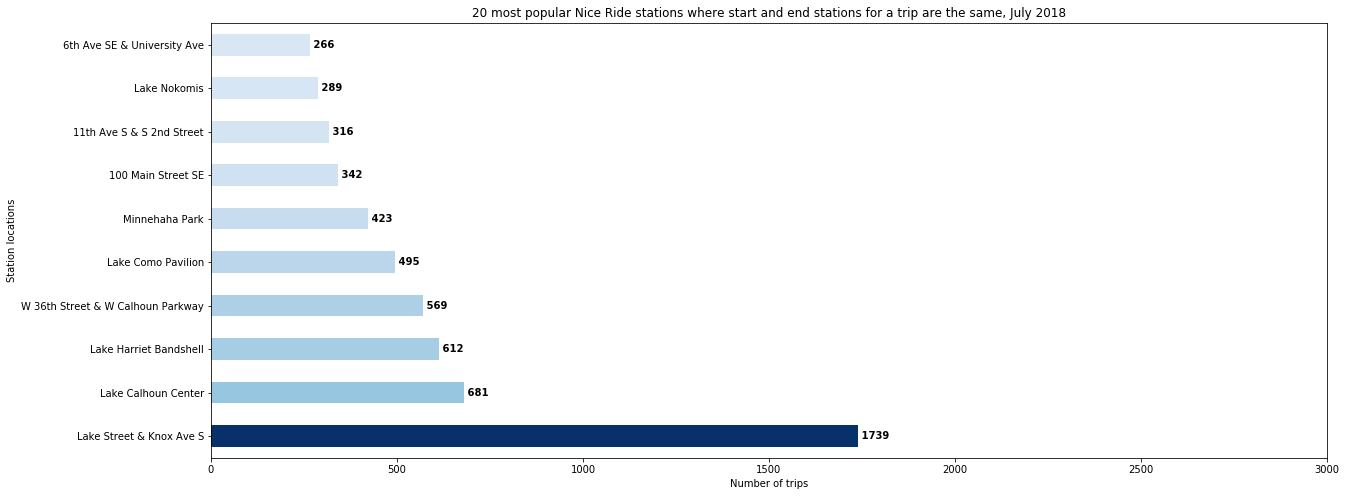

In [241]:
df_loops = df.loc[(df['start station id'] == df['end station id'])]
top_20_loop_stations = df_loops['start station name'].value_counts()[:10]

stations_bar(top_20_loop_stations,
             'Blues',
             '20 most popular Nice Ride stations where start and end stations for a trip are the same, {} {}'\
             .format(input_month,input_year),
             x_max=3000)

So even though the Lake Street & Knox Ave S station is by far the most common starting and ending station for trips, nearly half of those trips already start and end at that single station.

### Bike flow: or, where the balancers will be needed most

A lot of the same stations are on the most popular start and end lists. What these three graphs don't show us is the "flow" of bikes.
* Stations that are the most popular starting points need to have additional bikes distributed to them as riders take bikes away.
* Bikes need to be taken from stations that are the most popular destinations, to make space for additional riders as they arrive at the end of their trips.

In addition to the general frequency of each station's use, this flow is what will make a station significant to Nice Ride's team of balancers.

__In the graph below, all of the stations' locations are plotted, with size indicating overall frequency of use, and color representing whether they are more popular as a starting point (red) or destination (green).__

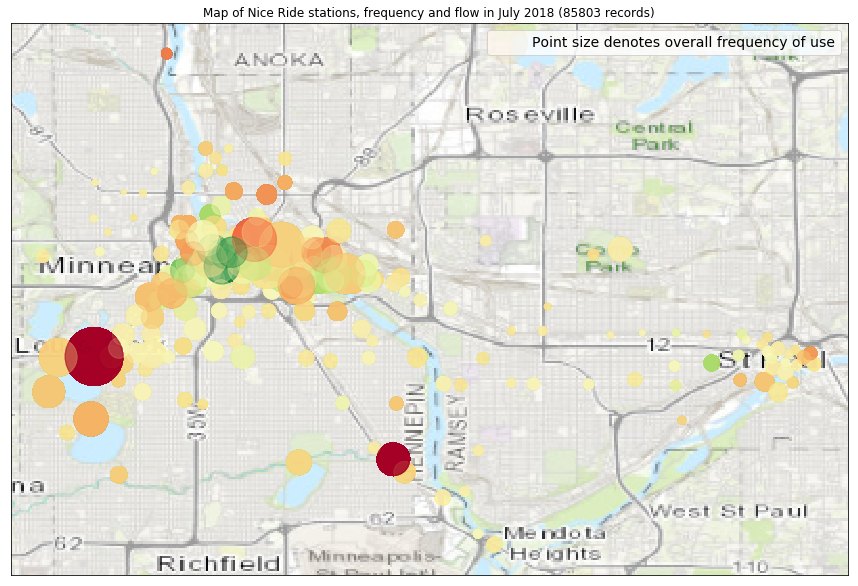

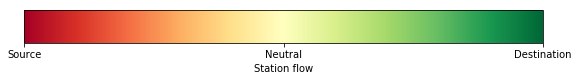

In [242]:
station_map(df_one_day_duration)

This is admittedly a noisy graph, but we can focus on just the extremes--by default, the upper and lower 25%. 

These are the stations most in need of balancing:

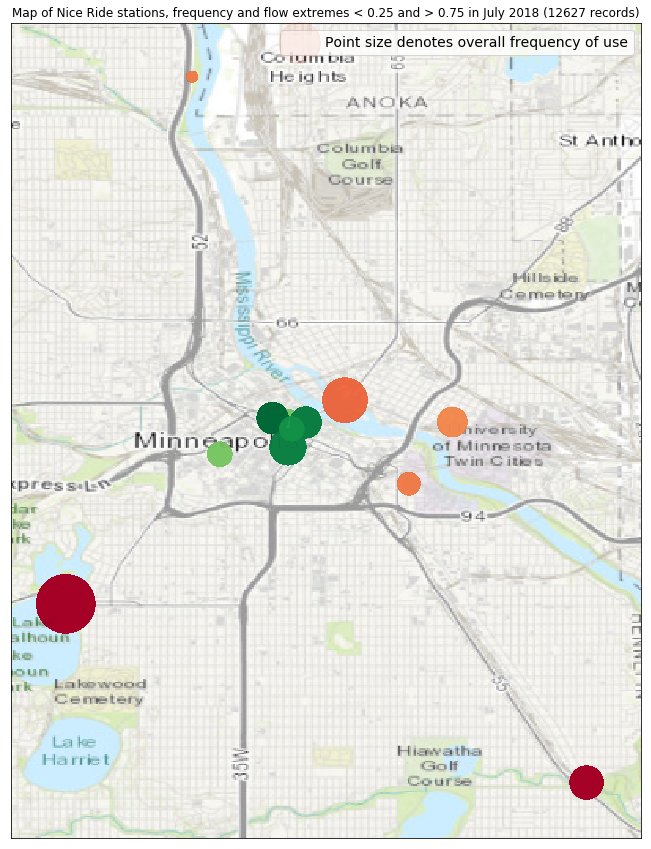

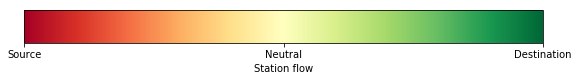

In [243]:
station_map(df_one_day_duration, flow_extreme=True)

If the focus needs to be on stations that are the most popular destinations for riders, we can look at that as well:

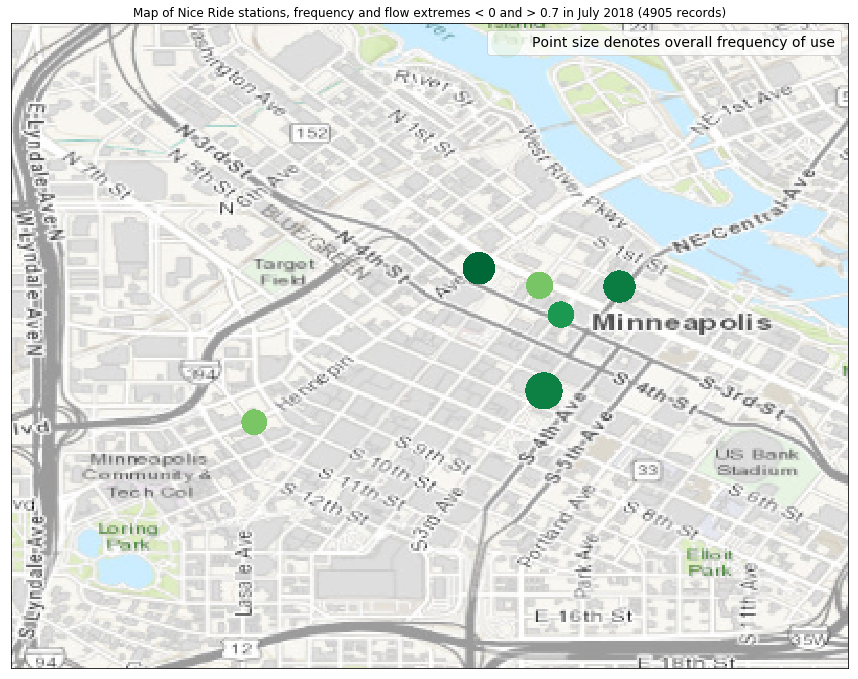

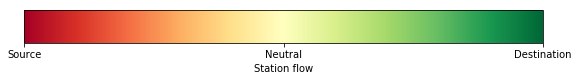

In [244]:
station_map(df_one_day_duration, 
            flow_extreme=True,
            flow_low = 0,
            flow_high=.7)

As could be expected, the most popular destinations are in the heart of downtown Minneapolis, and the most popular starting points are at points outside of downtown.

## Further research:

* My analysis examined overall trip numbers and durations, but did not take time of day, or day of the week, into account. It would be interesting to summarize trip data in these two ways, to see the (assumed) periodicity of morning and evening commutes, or to compare weekday trips to trips taken on weekends. Are there quiet parts of the day where Nice Ride could offer some kind of incentives to encourage ridership? 

* I am interested in not just start and end points, but how they connect. Nice Ride bikes' locations during trips aren't a part of their public data, so specific routes can't be determined--but for the trips where the start and end points aren't the same, what does that flow of trips look like when plotted on a map? Again, this could be broken down by time of day or day of the week (an animation demonstrating this migration of riders over a period of time would be pretty cool). This could help determine future station placement, or serve as further demonstration of where "balancing" bikes could help Nice Ride ensure that resources are available where and when riders want them.

* I took a look at the most popular/least popular stations, with an eye toward anticipated demand. I only broke this data down by month, however--I expect Nice Ride will want to anticipate demand on a periodic basis throughout each day, for example before morning and evening commutes on weekdays, and periodically throughout the day on weekends. Further analysis could find those trends that will drive balancers' daily work.

* More information about station status (station capacity; continuous data about slots or percent filled) would also make dispatching more accurate. Stations have a variable capacity, so knowing the popular destinations could be helpful for balancers--a station with a large capacity won't have to be visited as often.